# **Capital Deepening Dredging**

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [272]:
Dredge_power = 700 #kW
Production_rate_clay = 1800 + 200/(1000-500)*(3000-1800) #m3/h
Production_rate_sand = 1800 + 200/(1000-500)*(3000-1800)
Production_rate_cemented = 400 + 200/(1000-500)*(700-400)

for soil_type, production_rate in zip(['clay', 'sand', 'cemented sand'], 
                                      [Production_rate_clay, Production_rate_sand, Production_rate_cemented]):
    print(f'Production rate of {soil_type}: {production_rate:.1f} m3/h')
    print(f'Maximum weekly production rate of {soil_type}: {production_rate*24*7:.1f} m3/week\n')

Production rate of clay: 2280.0 m3/h
Maximum weekly production rate of clay: 383040.0 m3/week

Production rate of sand: 2280.0 m3/h
Maximum weekly production rate of sand: 383040.0 m3/week

Production rate of cemented sand: 520.0 m3/h
Maximum weekly production rate of cemented sand: 87360.0 m3/week



**Transporting clay and cemented material using pipeline**

In [273]:
rho_sand = 2000
rho_water = 1025
rho_cemented = 2400
rho_clay = 1800
rho_mixture = 1500
rho_mixture_cemented = 1250

#Sand
n_sand = 0.5
k0_sand= 2.5 * 10**-5
k1_sand = 5 * 10**-5
friction_angle_sand= 30

#Cemented
n_cemented = 0.32
k0_cemented = 2*10**-6
k1_cemented = 5*10**-6
friction_angle_cemented = 30

#clay
n_clay = 0.55
k0_clay = 1*10**-9
k1_clay = 1 * 10**-6
friction_angle_clay = 15

def calc_vm(Qg,rho_s, rho_w, rho_m, n0, D, ft = 1):
    return Qg*(rho_s-rho_w)*(1-n0) / ((rho_m-rho_w)*np.pi/4*D**2) /ft
print('Velocity clay (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_clay, rho_w = rho_water, rho_m = rho_mixture, n0 = n_clay, D=0.8),2), 'm/s')
print('Velocity sand (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_sand, rho_w = rho_water, rho_m = rho_mixture, n0 = n_sand, D=0.8),2), 'm/s')
print('Velocity cemented sand (0.8 m diameter):', round(calc_vm(Qg = 1,rho_s = rho_cemented, rho_w = rho_water, rho_m = rho_mixture_cemented, n0 = n_cemented, D=0.8),2), 'm/s')

Velocity clay (0.8 m diameter): 1.46 m/s
Velocity sand (0.8 m diameter): 2.04 m/s
Velocity cemented sand (0.8 m diameter): 8.27 m/s


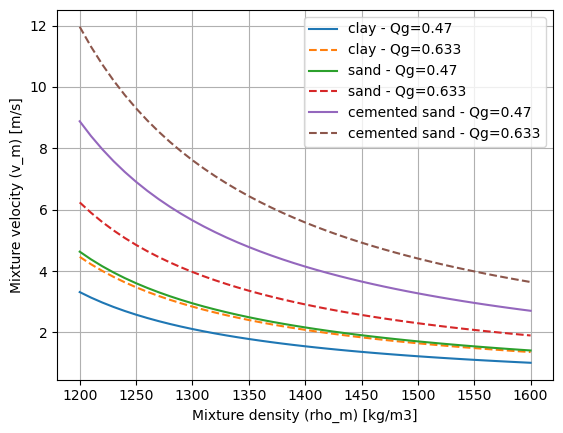

In [274]:
# compute vm series per soil type
D = 0.6
rho_s_list = [rho_clay, rho_sand, rho_cemented]
n0_list = [n_clay, n_sand, n_cemented]
soil_names = ['clay', 'sand', 'cemented sand']

rho_serie = np.arange(1200,1600+10,10)
vm_avg_series = []
vm_peak_series = []

for rho_s_val, n0_val, rho_m in zip(rho_s_list, n0_list, rho_serie):
    vm_avg_series.append([calc_vm(Qg=0.47, rho_s=rho_s_val, rho_w=rho_water, rho_m=rho_m, n0=n0_val, D=D)
                          for rho_m in rho_serie])
    vm_peak_series.append([calc_vm(Qg=0.633, rho_s=rho_s_val, rho_w=rho_water, rho_m=rho_m, n0=n0_val, D=D)
                           for rho_m in rho_serie])

for name, vm_avg_s, vm_peak_s in zip(soil_names, vm_avg_series, vm_peak_series):
    plt.plot(rho_serie, vm_avg_s, label=f'{name} - Qg=0.47')
    plt.plot(rho_serie, vm_peak_s, '--', label=f'{name} - Qg=0.633')

plt.xlabel('Mixture density (rho_m) [kg/m3]')
plt.ylabel('Mixture velocity (v_m) [m/s]')
plt.legend()
plt.grid(True)
plt.show()
# a=0.633*0.75
# print(a)

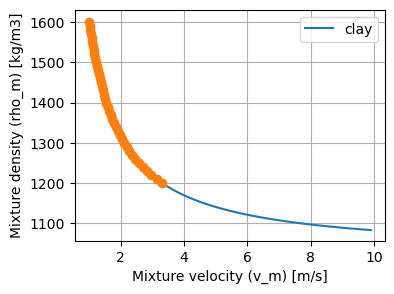

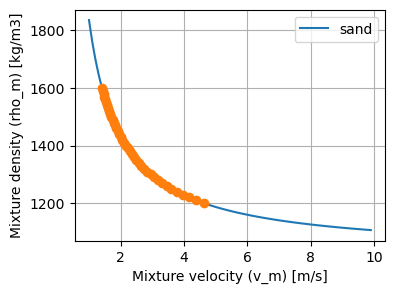

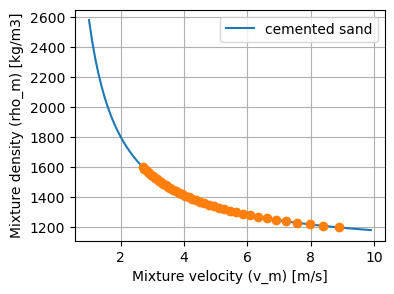

Formula is correct; plotted rho_m vs vm for each soil.


In [275]:
Pipe_D = 0.6
A = 0.25*np.pi*D**2

def calc_rho_m(Q,A,n,ft,rho_s,rho_w,vm):
    C1 = Q/A * (1-n) / ft
    return (C1*rho_s - C1*rho_w + rho_w*vm)/vm

vm_serie = np.arange(3,10,0.1)
rho_m_per_soil = (rho_mixture, rho_mixture, rho_mixture_cemented)
# plot results
for name, rho_series in zip(soil_names, rho_m_per_soil):
    D = Pipe_D
    A = 0.25*np.pi*D**2

    vm_serie = np.arange(1,10,0.1)

    # compute rho_m over the vm range for each soil (use corresponding n0)
    rho_m_per_soil = []
    for rho_s, n0 in zip(rho_s_list, n0_list):
        rho_m_per_soil.append([
            calc_rho_m(Q=0.47, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=vm)
            for vm in vm_serie])

for i, (name, rho_series) in enumerate(zip(soil_names, rho_m_per_soil)):
    plt.figure(figsize=(4,3))
    plt.plot(vm_serie, rho_series, label=name)
    plt.plot(vm_avg_series[i], rho_serie, 'o')  # mark the previous points for Qg=1
    plt.xlabel('Mixture velocity (v_m) [m/s]')
    plt.ylabel('Mixture density (rho_m) [kg/m3]')
    plt.legend()
    plt.grid(True)
    plt.show()
print('Formula is correct; plotted rho_m vs vm for each soil.')

In [276]:
L = 500 #m from basin to LR area
resistance_coefficient = 0.012
Pipe_D = 0.6

def calc_Delta_P(lambda_, rho_m,rho_w,L,D,v):
    g=9.81
    return 1/2*lambda_ * rho_m /rho_w *L/D*(v**2)/g*rho_m*g

v = 0.633/(0.25*np.pi*Pipe_D**2) # Q (1 m3/s) / A [m2]

def calc_Delta_P2(rho_m,He):
    return rho_m*9.81*He

rho_m = [rho_mixture, rho_mixture, rho_mixture_cemented]
for soil_name, rho, n, He in zip(soil_names, (rho_m), (n0_list), (15,18,19.5)):    
    DeltaP1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho, rho_w=rho_water, L = 1000,D = Pipe_D,v = v)
    DeltaP2 = calc_Delta_P2(rho, He)
    DeltaP3 = (0.15*2 + 1.0 + 0.45) * 0.5 * rho * v**2  #for 2 bends, 1 exit, 1 entrance
    Total_Delta_P = DeltaP1 + DeltaP2 + DeltaP3

    print(soil_name)
    print(f'  - Delta P 1: {DeltaP1/1000:.2f} kN/m2')
    print(f'  - Delta P 2: {DeltaP2/1000:.2f} kN/m2')
    print(f'  - Delta P 3: {DeltaP3/1000:.2f} kN/m2')
    print(f'  - Total Delta P: {Total_Delta_P/1000:.2f} kN/m2\n')



clay
  - Delta P 1: 110.02 kN/m2
  - Delta P 2: 220.72 kN/m2
  - Delta P 3: 6.58 kN/m2
  - Total Delta P: 337.33 kN/m2

sand
  - Delta P 1: 110.02 kN/m2
  - Delta P 2: 264.87 kN/m2
  - Delta P 3: 6.58 kN/m2
  - Total Delta P: 381.47 kN/m2

cemented sand
  - Delta P 1: 76.40 kN/m2
  - Delta P 2: 239.12 kN/m2
  - Delta P 3: 5.48 kN/m2
  - Total Delta P: 321.01 kN/m2



In [277]:
def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1

V_sand, B_top_sand = V_trench(B = 200,H = 3,phi = 30, L=750) 
V_clay, B_top_clay = V_trench(B = 200,H = 2,phi = 15, L=750)
V_cemented, B_top_cemented = V_trench(B = 200,H = 1.5,phi = 30, L=750)
print('Volume of sand:', round(V_sand,0) ,'m3, top width:', round(B_top_sand,0), 'm')
print('Volume of clay:', round(V_clay,0) ,'m3, top width:', round(B_top_clay,0), 'm')
print('Volume of cemented sand:', round(V_cemented,0) ,'m3, top width:', round(B_top_cemented,0), 'm \n')

Volume of sand: 461691.0 m3, top width: 210.0 m
Volume of clay: 311196.0 m3, top width: 215.0 m
Volume of cemented sand: 227923.0 m3, top width: 205.0 m 



Pumping Clay Short Pipeline

In [278]:
Pipe_D = 0.6 #m
Q_clay_sand = 0.633  #m3/s
Q_cemented = 0.144  #m3/s
A = 0.25*np.pi*Pipe_D**2 #m2

V_sand =  Q_clay_sand / A
V_cemsand = Q_cemented / A
print('Volume flow rate sand/clay:', round(V_sand,2), 'm3/s')
# print('Volume flow rate cemented sand:', round(V_cemsand,2), 'm3/s\n')


time_pumping_sand = V_sand / (Q_clay_sand) /3600 #h
time_pumping_clay = V_clay / (Q_clay_sand) /3600 #h
time_pumping_cemented = V_cemented / (Q_cemented) /3600 #h

Energy_per_soil = []
for Qg, soil_name, rho_s, n0 in zip([Q_clay_sand, Q_clay_sand, Q_cemented],
                                    soil_names,
                                    rho_s_list,
                                    n0_list):
    v = Qg / A
    rho_m = calc_rho_m(Q=Qg, A=A, n=n0, ft=1, rho_s=rho_s, rho_w=rho_water, vm=v)
    DeltaP1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho_m, rho_w=rho_water, L = 200,D = Pipe_D,v = v)
    if soil_name == 'clay':
        He = DeltaP1/(rho_m*9.81)
    elif soil_name == 'sand':
        He = DeltaP2/(rho_m*9.81)
    else:
        He = DeltaP3/(rho_m*9.81)
    DeltaP2 = calc_Delta_P2(rho_m, He)
    DeltaP3 = (0.15*2 + 1.0 + 0.45) * 0.5 * rho_m * v**2  #for 2 bends, 1 exit, 1 entrance
    Total_Delta_P = DeltaP1 + DeltaP2 + DeltaP3 
    # Power_required = Total_Delta_P * Qg / 1000 #kW
    Power_hydraulic = rho_mixture * 9.81 * Total_Delta_P * Qg / 1000 #kW

    Energy_per_soil.append(Power_hydraulic/Dredge_power*100) #%

    # print(soil_name)
    # print(f'  - Power required: {Power_hydraulic:.2f} kW')

Energy_clay = Power_hydraulic* time_pumping_clay
# Energy_sand= Power_hydraulic * time_pumping_sand
# Energy_cemented= Power_hydraulic * time_pumping_cemented
# TOTAL_PUMPING_ENERGY =  Energy_clay + Energy_sand + Energy_cemented
# print(f'Total pumping energy: {TOTAL_PUMPING_ENERGY:.2f} kWh')
print(f'Energy used for clay pumping: {Energy_clay:.2f} kWh')


Volume flow rate sand/clay: 2.24 m3/s
Energy used for clay pumping: 2610785.28 kWh
